# 📤  — Predições no Conjunto de Teste e Submissão
## Ligia NLP Challenge — Detecção de Fake News

| Informação | Detalhe |
|---|---|
| **Entrada** | `data/processed/char_ngrams/tfidf_vectorizer_char_ngrams.joblib`, modelos em `models/mlclassico/` |
| **Saída** | `data/processed/submission_xgboost.csv`, `submission_linearsvc.csv`, `submission_ensemble_xgb_svc.csv` |
| **Notebook anterior** | `3.1-hyperparameter-optimization.ipynb` |
| **Próximo Notebook** | `5.0-tinybert.ipynb` (deep learning) |

## Objetivo
Gerar submissões individuais para os melhores modelos clássicos e depois combiná-los via ensemble.

## Pipeline
1. Carregar dados de teste limpos e vetorizador TF-IDF (char-ngrams)
2. Vetorizar conjunto de teste uma só vez
3. **[Independente]** Predições + submissão — **XGBoost nativo** (`model_1_xgboost.joblib`)
4. **[Independente]** Predições + submissão — **LinearSVC otimizado** (`linearsvc_optimized.joblib`)
5. Análise comparativa das predições (distribuição + concordância + discordâncias)
6. **Ensemble final** por votação → `submission_ensemble_xgb_svc.csv`

## Formato de saída esperado pelo Kaggle
```
id,target
5398,1
5503,0
...
```


## 1. Setup

In [1]:
import os, time, json
import warnings
warnings.filterwarnings('ignore')
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminhos principais
MODEL_DIR     = '../models/mlclassico'
CHAR_DIR      = '../data/processed/char_ngrams'
OUTPUT_DIR    = '../data/processed'
FIGURES_DIR   = '../reports/figures'

os.makedirs(FIGURES_DIR, exist_ok=True)
print("✓ Setup concluído")


✓ Setup concluído


## 2. Carregar Dados de Teste e Vetorizador TF-IDF


In [2]:
# IDs originais (raw)
df_raw = pd.read_csv('../data/raw/test.csv')
ids = df_raw['id'].values

# Texto pré-processado (pipeline char-ngrams)
df_clean = pd.read_csv(os.path.join(CHAR_DIR, 'test_clean.csv'))
df_clean['title']     = df_clean['title'].fillna('')
df_clean['text']      = df_clean['text'].fillna('')
df_clean['full_text'] = df_clean['title'] + ' ' + df_clean['text']

assert len(ids) == len(df_clean), (
    f"Mismatch: {len(ids)} IDs vs {len(df_clean)} textos"
)

# Vetorizador TF-IDF char-ngrams (treinado no notebook 3.0)
vect_path  = os.path.join(CHAR_DIR, 'tfidf_vectorizer_char_ngrams.joblib')
vectorizer = joblib.load(vect_path)

print(f"✓ {len(df_clean):,} amostras de teste carregadas")
print(f"✓ Vetorizador TF-IDF carregado")
print(f"  vocab    : {len(vectorizer.vocabulary_):,} tokens")
print(f"  analyzer : {vectorizer.analyzer}")
print(f"  ngram    : {vectorizer.ngram_range}")


✓ 5,712 amostras de teste carregadas
✓ Vetorizador TF-IDF carregado
  vocab    : 50,000 tokens
  analyzer : char
  ngram    : (3, 5)


## 3. Vetorizar Dados de Teste


In [3]:
print("Vetorizando conjunto de teste...")
t0 = time.time()
X_test = vectorizer.transform(df_clean['full_text'])
elapsed = time.time() - t0

print(f"✓ Vetorização concluída em {elapsed:.2f}s")
print(f"  Shape: {X_test.shape[0]:,} docs × {X_test.shape[1]:,} features")


Vetorizando conjunto de teste...
✓ Vetorização concluída em 23.09s
  Shape: 5,712 docs × 50,000 features


## 4. Predições — XGBoost

Modelo base treinado no notebook 3.0 (`model_1_xgboost.joblib`). Obteve bom desempenho na validação e é o ponto de partida da submissão clássica.


In [4]:
xgb_path  = os.path.join(MODEL_DIR, 'char-ngrams-baseline', 'model_1_xgboost.joblib')
xgb_model = joblib.load(xgb_path)
print(f"✓ {type(xgb_model).__name__} carregado — {xgb_path}")

t0 = time.time()
preds_xgb = xgb_model.predict(X_test)
elapsed   = time.time() - t0

print(f"\n✓ Predições geradas em {elapsed:.2f}s")
print(f"\nDistribuição XGBoost:")
for cls, cnt in zip(*np.unique(preds_xgb, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(preds_xgb):.1%})")

# Salvar submissão
xgb_sub_path = os.path.join(OUTPUT_DIR, 'submission_xgboost.csv')
pd.DataFrame({'id': ids, 'target': preds_xgb.astype(int)}).to_csv(xgb_sub_path, index=False)
print(f"\n✓ Submissão salva em: {xgb_sub_path}")


✓ XGBClassifier carregado — ../models/mlclassico\char-ngrams-baseline\model_1_xgboost.joblib

✓ Predições geradas em 0.06s

Distribuição XGBoost:
  Classe 0 (Real): 4,281  (74.9%)
  Classe 1 (Fake): 1,431  (25.1%)

✓ Submissão salva em: ../data/processed\submission_xgboost.csv


## 5. Predições — LinearSVC Otimizado

Modelo com hiperparâmetros ajustados no notebook 3.1 (`linearsvc_optimized.joblib`). 


In [5]:
svc_path  = os.path.join(MODEL_DIR, 'optimized', 'linearsvc_optimized.joblib')
svc_model = joblib.load(svc_path)
print(f"✓ {type(svc_model).__name__} carregado — {svc_path}")

t0 = time.time()
preds_svc = svc_model.predict(X_test)
elapsed   = time.time() - t0

print(f"\n✓ Predições geradas em {elapsed:.2f}s")
print(f"\nDistribuição LinearSVC:")
for cls, cnt in zip(*np.unique(preds_svc, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(preds_svc):.1%})")

# Salvar submissão
svc_sub_path = os.path.join(OUTPUT_DIR, 'submission_linearsvc.csv')
pd.DataFrame({'id': ids, 'target': preds_svc.astype(int)}).to_csv(svc_sub_path, index=False)
print(f"\n✓ Submissão salva em: {svc_sub_path}")


✓ CalibratedClassifierCV carregado — ../models/mlclassico\optimized\linearsvc_optimized.joblib

✓ Predições geradas em 0.12s

Distribuição LinearSVC:
  Classe 0 (Real): 4,286  (75.0%)
  Classe 1 (Fake): 1,426  (25.0%)

✓ Submissão salva em: ../data/processed\submission_linearsvc.csv


## 6. Análise das Predições Independentes

Comparação das distribuições e taxa de concordância entre XGBoost e LinearSVC antes de montar o ensemble.


  CONCORDÂNCIA XGBoost × LinearSVC
  Total de amostras : 5,712
  Concordam         : 5,707  (99.9%)
  Discordam         : 5  (0.1%)

Padrão das discordâncias (xgb  →  svc):
 xgb  svc  count
   1    0      5


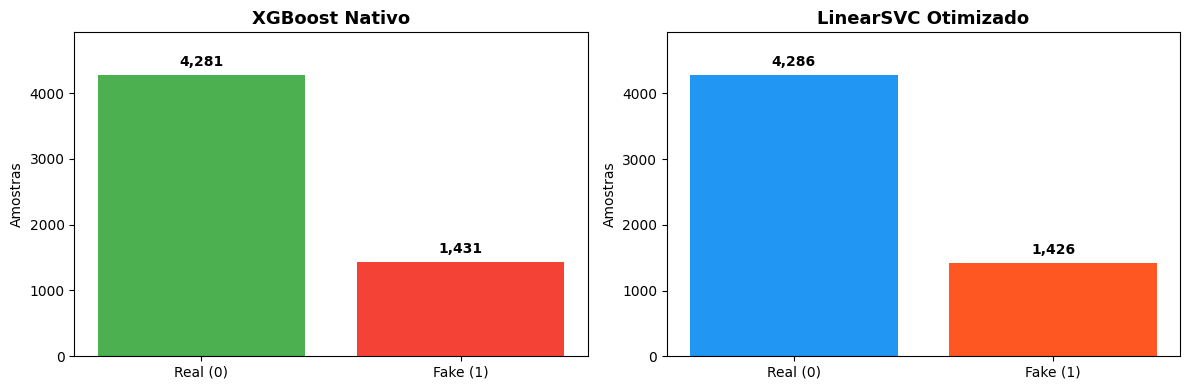

✓ Figura salva em: ../reports/figures\predictions_comparison.png


In [6]:
# DataFrame consolidado de predições
pred_df = pd.DataFrame({
    'id'  : ids,
    'xgb' : preds_xgb.astype(int),
    'svc' : preds_svc.astype(int),
})

agree_mask = pred_df['xgb'] == pred_df['svc']
n_agree    = int(agree_mask.sum())
n_disagree = int((~agree_mask).sum())
pct_agree  = n_agree / len(pred_df)

print("=" * 55)
print("  CONCORDÂNCIA XGBoost × LinearSVC")
print("=" * 55)
print(f"  Total de amostras : {len(pred_df):,}")
print(f"  Concordam         : {n_agree:,}  ({pct_agree:.1%})")
print(f"  Discordam         : {n_disagree:,}  ({1 - pct_agree:.1%})")
print()
print("Padrão das discordâncias (xgb  →  svc):")
print(pred_df[~agree_mask].groupby(['xgb', 'svc']).size()
      .rename('count').reset_index().to_string(index=False))

# ── Plots ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (col, label, color_pair) in zip(axes, [
    ('xgb', 'XGBoost Nativo',      ['#4CAF50', '#F44336']),
    ('svc', 'LinearSVC Otimizado', ['#2196F3', '#FF5722']),
]):
    counts = pred_df[col].value_counts().sort_index()
    bars = ax.bar(['Real (0)', 'Fake (1)'], counts.values, color=color_pair)
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.set_ylabel('Amostras')
    ax.set_ylim(0, counts.max() * 1.15)
    for b, v in zip(bars, counts.values):
        ax.text(b.get_x() + b.get_width() / 2,
                b.get_height() + counts.max() * 0.02,
                f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
fig_path = os.path.join(FIGURES_DIR, 'predictions_comparison.png')
plt.savefig(fig_path, dpi=120, bbox_inches='tight')
plt.show()
print(f"✓ Figura salva em: {fig_path}")


## 7. Ensemble Final — XGBoost + LinearSVC

**Estratégia de votação (2 modelos):**
- Quando os dois **concordam** → usa a predição diretamente
- Quando **discordam** → o **LinearSVC desempata** (wins)


In [7]:
# Ensemble: onde concordam usa predição direta; onde discordam LinearSVC wins
ensemble_preds = np.where(agree_mask.values, pred_df['xgb'].values, pred_df['svc'].values)

ensemble_path = os.path.join(OUTPUT_DIR, 'submission_ensemble_xgb_svc_svc_wins.csv')
pd.DataFrame({'id': ids, 'target': ensemble_preds.astype(int)}).to_csv(ensemble_path, index=False)

# ── Relatório final ────────────────────────────────────────────────────
print("=" * 55)
print("  ENSEMBLE FINAL — XGBoost + LinearSVC (SVC wins)")
print("=" * 55)
print(f"\n  Amostras com consenso     : {n_agree:,}  ({pct_agree:.1%})")
print(f"  Amostras com desempate    : {n_disagree:,}  ({1 - pct_agree:.1%})  → LinearSVC decide")
print(f"\nDistribuição do Ensemble:")
for cls, cnt in zip(*np.unique(ensemble_preds, return_counts=True)):
    label = 'Fake' if cls == 1 else 'Real'
    print(f"  Classe {int(cls)} ({label}): {cnt:,}  ({cnt / len(ensemble_preds):.1%})")

print(f"\n✅ Submissão ensemble salva em: {ensemble_path}")


  ENSEMBLE FINAL — XGBoost + LinearSVC (SVC wins)

  Amostras com consenso     : 5,707  (99.9%)
  Amostras com desempate    : 5  (0.1%)  → LinearSVC decide

Distribuição do Ensemble:
  Classe 0 (Real): 4,286  (75.0%)
  Classe 1 (Fake): 1,426  (25.0%)

✅ Submissão ensemble salva em: ../data/processed\submission_ensemble_xgb_svc_svc_wins.csv


## 8. Interpretabilidade — LIME no Ensemble Final

O **LIME** (*Local Interpretable Model-agnostic Explanations*) aproxima o comportamento do modelo localmente em torno de cada amostra, identificando quais palavras mais contribuíram para a predição.

**Estratégia implementada:**
- **XGBoost**: probabilidades via `predict_proba`
- **LinearSVC**: pseudo-probabilidades via `sigmoid(decision_function)`
- **Ensemble suave**: média das duas estimativas de probabilidade (consistente com a votação por maioria usada na submissão)


In [8]:
# ─── IMPORTAÇÕES LIME ─────────────────────────────────────────────────────────
from lime.lime_text import LimeTextExplainer
from scipy.special import expit  # sigmoid

SEED_LIME   = 42
CLASS_NAMES = ["Real", "Fake"]

# ─── CARREGAR AMOSTRAS DE VALIDAÇÃO PARA DEMONSTRAÇÃO ─────────────────────────
train_clean  = pd.read_csv(os.path.join(CHAR_DIR, 'train_clean.csv'))
train_clean['title']     = train_clean['title'].fillna('')
train_clean['text']      = train_clean['text'].fillna('')
train_clean['full_text'] = train_clean['title'] + ' ' + train_clean['text']

val_idx  = pd.read_csv(os.path.join(CHAR_DIR, 'val_indices.csv'))
y_val_df = pd.read_csv(os.path.join(CHAR_DIR, 'y_val.csv'))

df_val_lime = train_clean.iloc[val_idx.values.flatten()].reset_index(drop=True)
df_val_lime['label'] = y_val_df.values.flatten()

print(f"✓ {len(df_val_lime):,} amostras de validação carregadas para LIME")
print(f"  Distribuição: {df_val_lime['label'].value_counts().to_dict()}")


✓ 4,468 amostras de validação carregadas para LIME
  Distribuição: {0: 3399, 1: 1069}


In [15]:
# ─── FUNÇÃO DE PREDIÇÃO DO ENSEMBLE PARA O LIME ───────────────────────────────
def predict_ensemble_proba(texts):
    """
    Retorna probabilidades suaves para o ensemble XGBoost + LinearSVC.
      - XGBoost              : predict_proba  → probabilidades calibradas
      - LinearSVC/Calibrated : predict_proba  → probabilidades calibradas (CalibratedClassifierCV)
    O ensemble é a média das duas estimativas (soft voting).
    """
    X_tfidf = vectorizer.transform(texts)

    # XGBoost — probabilidades
    proba_xgb = xgb_model.predict_proba(X_tfidf)  # (n, 2)

    # LinearSVC (CalibratedClassifierCV) — já possui predict_proba
    if hasattr(svc_model, 'predict_proba'):
        proba_svc = svc_model.predict_proba(X_tfidf)  # (n, 2)
    else:
        # fallback: sigmoid sobre decision_function
        decision = svc_model.decision_function(X_tfidf)
        prob_fake = expit(decision)
        proba_svc = np.column_stack([1 - prob_fake, prob_fake])

    # Ensemble suave (média)
    return (proba_xgb + proba_svc) / 2


# ─── EXPLAINER ────────────────────────────────────────────────────────────────
explainer_lime = LimeTextExplainer(
    class_names      = CLASS_NAMES,
    split_expression = r"\W+",
    random_state     = SEED_LIME,
)


# ─── FUNÇÃO REUTILIZÁVEL ──────────────────────────────────────────────────────
def explain_lime_ensemble(text, num_features=15, num_samples=500, label=None):
    """
    Gera e exibe explicação LIME para uma amostra de texto no ensemble.

    Parâmetros
    ----------
    text         : str  — texto a explicar
    num_features : int  — número de palavras-chave no gráfico
    num_samples  : int  — amostras para aproximação local do LIME
    label        : int  — 0 = Real, 1 = Fake (None → usa predição do ensemble)
    """
    proba      = predict_ensemble_proba([text])[0]
    pred_class = int(np.argmax(proba))

    if label is None:
        label = pred_class

    exp = explainer_lime.explain_instance(
        text,
        predict_ensemble_proba,
        num_features = num_features,
        num_samples  = num_samples,
        labels       = [label],
    )

    print(f"Texto    : {text[:130]}{'...' if len(text) > 130 else ''}")
    print(f"Predição : {CLASS_NAMES[pred_class]}  "
          f"(Real: {proba[0]:.4f} | Fake: {proba[1]:.4f})")
    print(f"Explicando classe: {CLASS_NAMES[label]}\n")

    fig = exp.as_pyplot_figure(label=label)
    fig.set_size_inches(10, 5)
    plt.title(
        f"LIME — Ensemble (XGBoost + LinearSVC) | "
        f"classe '{CLASS_NAMES[label]}' | confiança {proba[label]:.2%}",
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()

    return exp


### 8.1 Exemplos — Primeiras amostras da validação


AMOSTRA 1  |  Rótulo verdadeiro: Real
Texto    : Kentucky governor sues to close abortion clinic (Reuters) - Kentucky’s Republican Governor Matt Bevin has filed a lawsuit asking a...
Predição : Real  (Real: 0.9946 | Fake: 0.0054)
Explicando classe: Real



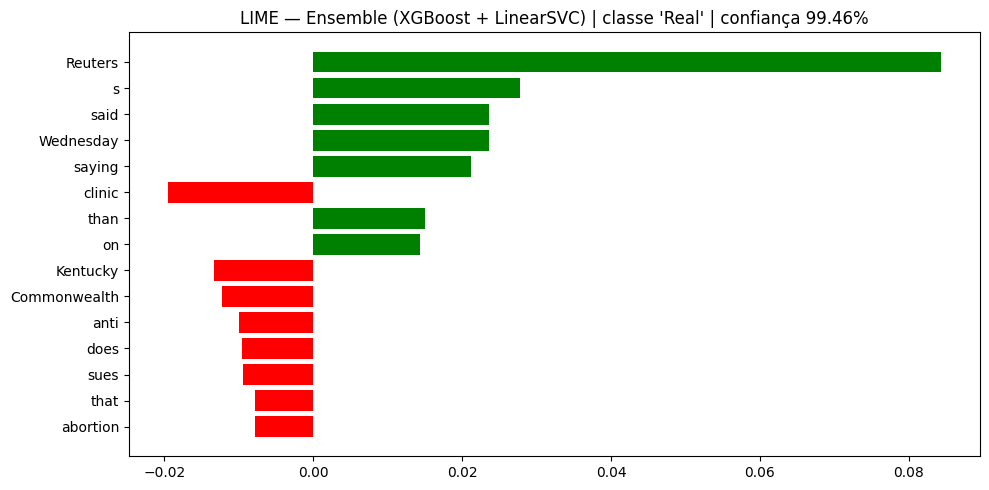


AMOSTRA 2  |  Rótulo verdadeiro: Real
Texto    : U.S. House approves bill to upgrade airport security WASHINGTON (Reuters) - The House of Representatives on Monday approved an avi...
Predição : Real  (Real: 0.9999 | Fake: 0.0001)
Explicando classe: Real



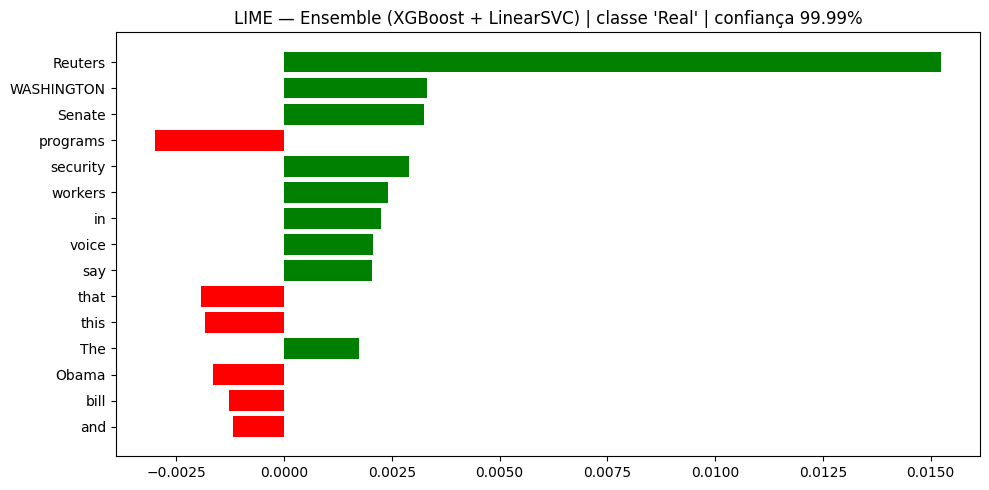


AMOSTRA 3  |  Rótulo verdadeiro: Real
Texto    : Dutch join Austria's lawsuit against German road toll plan AMSTERDAM (Reuters) - The Dutch government said on Wednesday it is join...
Predição : Real  (Real: 0.9998 | Fake: 0.0002)
Explicando classe: Real



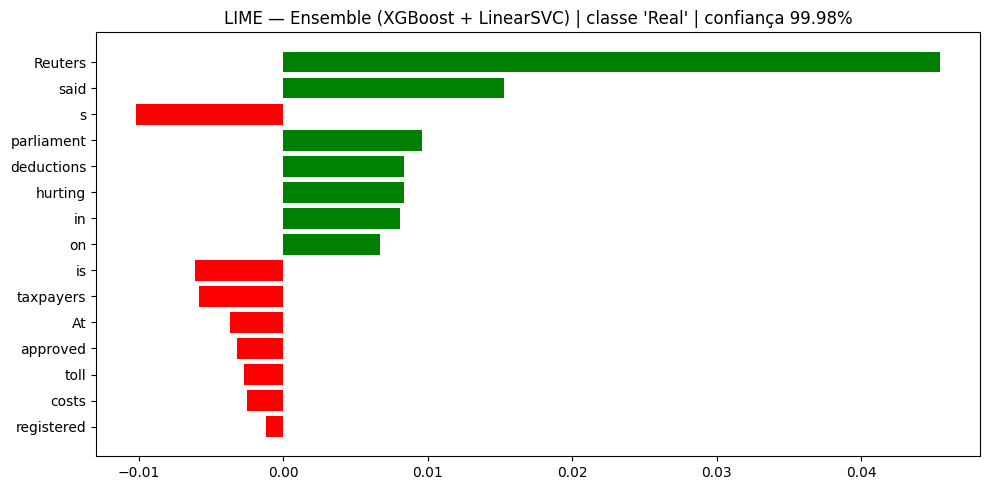

In [12]:
# ─── EXPLICAÇÕES PARA AS 3 PRIMEIRAS AMOSTRAS DA VALIDAÇÃO ───────────────────
for i in range(3):
    text  = df_val_lime.loc[i, 'full_text']
    label = int(df_val_lime.loc[i, 'label'])
    print(f"{'='*80}")
    print(f"AMOSTRA {i+1}  |  Rótulo verdadeiro: {CLASS_NAMES[label]}")
    print(f"{'='*80}")
    explain_lime_ensemble(text)
    print()


### 8.2 Comparação LIME — Real vs Fake

Explanações lado a lado para uma amostra genuinamente **Real** e uma genuinamente **Fake**, mostrando quais padrões de caracteres/palavras o ensemble associa a cada classe.


EXEMPLO — REAL (label=0)
Texto    : Kentucky governor sues to close abortion clinic (Reuters) - Kentucky’s Republican Governor Matt Bevin has filed a lawsuit asking a...
Predição : Real  (Real: 0.9946 | Fake: 0.0054)
Explicando classe: Real



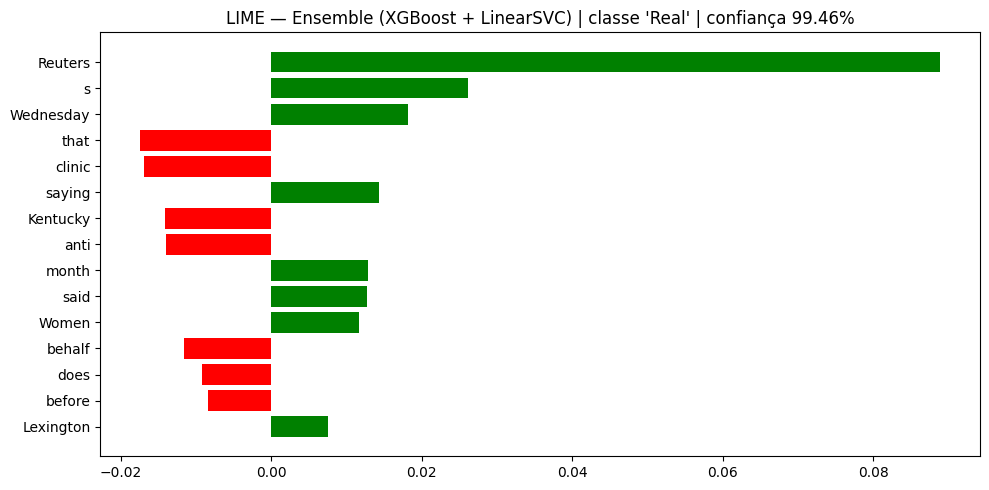

EXEMPLO — FAKE (label=1)
Texto    : 5 Reasons The Republicans Just Nominated The Worst Possible Candidate: Trump Donald Trump has cleared the Republican presidential ...
Predição : Fake  (Real: 0.0000 | Fake: 1.0000)
Explicando classe: Fake



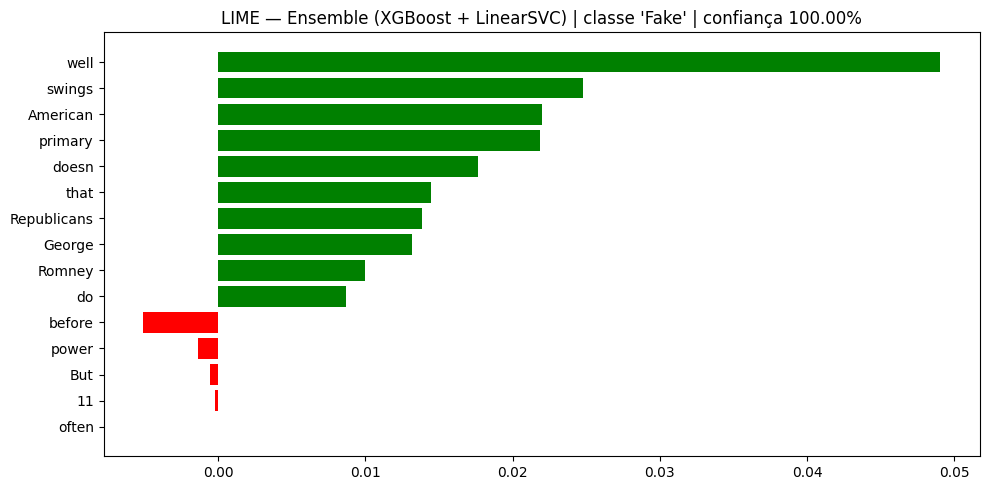

In [13]:
# ─── COMPARAÇÃO LIME: Real vs Fake ────────────────────────────────────────────
real_texts = df_val_lime[df_val_lime['label'] == 0]['full_text'].values
fake_texts = df_val_lime[df_val_lime['label'] == 1]['full_text'].values

print("=" * 80)
print("EXEMPLO — REAL (label=0)")
print("=" * 80)
explain_lime_ensemble(real_texts[0])

print("=" * 80)
print("EXEMPLO — FAKE (label=1)")
print("=" * 80)
explain_lime_ensemble(fake_texts[0])


### 8.3 Top Palavras Globais — Pesos LIME Agregados

Agrega os pesos LIME de múltiplas amostras para identificar quais palavras o ensemble considera mais discriminativas globalmente para cada classe.


Gerando explicações LIME para 40 amostras (pode levar ~1 min)...
  10/40 amostras processadas
  20/40 amostras processadas
  30/40 amostras processadas
  40/40 amostras processadas


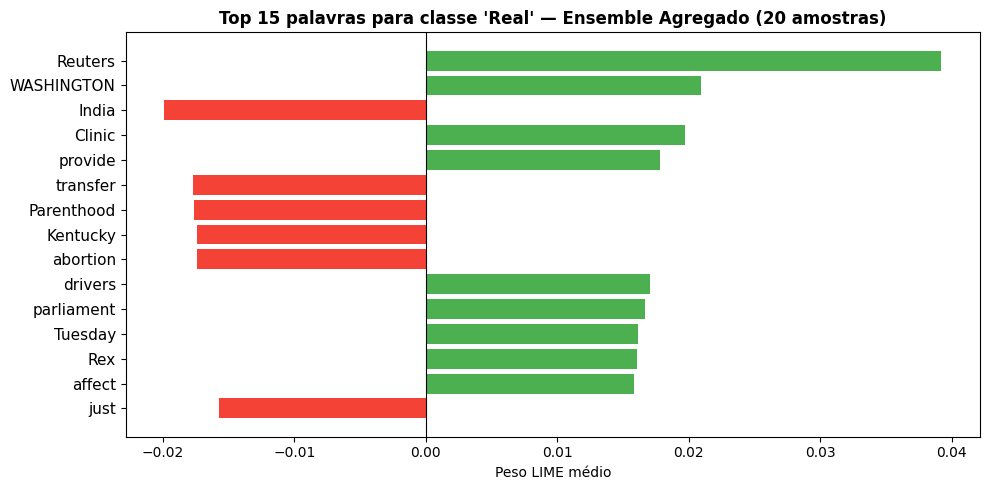

✓ Figura salva em: ../reports/figures\lime_top_words_real.png


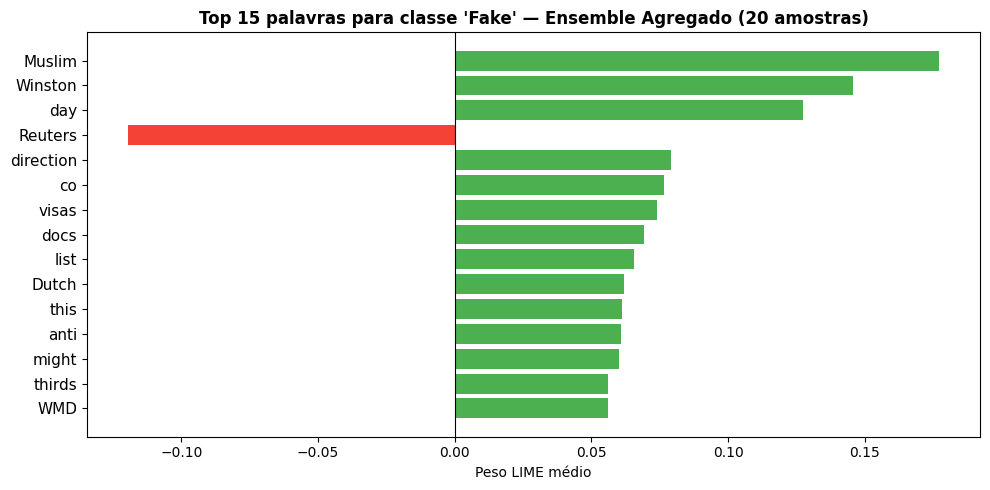

✓ Figura salva em: ../reports/figures\lime_top_words_fake.png


In [ ]:
# ─── PESOS LIME AGREGADOS (N amostras por classe) ─────────────────────────────
N_SAMPLES_PER_CLASS = 20   # amostras por classe para agregar

from collections import defaultdict

feat_weights = defaultdict(list)  # feature → [peso_1, peso_2, ...]

sample_texts   = (list(real_texts[:N_SAMPLES_PER_CLASS]) +
                   list(fake_texts[:N_SAMPLES_PER_CLASS]))
sample_labels  = [0] * N_SAMPLES_PER_CLASS + [1] * N_SAMPLES_PER_CLASS

print(f"Gerando explicações LIME para {len(sample_texts)} amostras")

for idx, (text, lbl) in enumerate(zip(sample_texts, sample_labels)):
    exp = explainer_lime.explain_instance(
        text,
        predict_ensemble_proba,
        num_features=15,
        num_samples=300,
        labels=[lbl],
    )
    for feat, weight in exp.as_list(label=lbl):
        feat_weights[(feat, lbl)].append(weight)

    if (idx + 1) % 10 == 0:
        print(f"  {idx + 1}/{len(sample_texts)} amostras processadas")

# ─── AGREGAÇÃO E PLOTAGEM ─────────────────────────────────────────────────────
aggregated = {(feat, lbl): np.mean(weights)
              for (feat, lbl), weights in feat_weights.items()}

TOP_K = 15

for label_idx, label_name in enumerate(CLASS_NAMES):
    class_feats = {feat: w for (feat, lbl), w in aggregated.items() if lbl == label_idx}
    sorted_feats = sorted(class_feats.items(), key=lambda x: abs(x[1]), reverse=True)[:TOP_K]

    feats, weights = zip(*sorted_feats) if sorted_feats else ([], [])
    colors = ['#4CAF50' if w > 0 else '#F44336' for w in weights]

    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(range(len(feats)), weights, color=colors)
    ax.set_yticks(range(len(feats)))
    ax.set_yticklabels(feats, fontsize=11)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel("Peso LIME médio")
    ax.set_title(
        f"Top {TOP_K} palavras para classe '{label_name}' — "
        f"Ensemble Agregado ({N_SAMPLES_PER_CLASS} amostras)",
        fontsize=12, fontweight='bold',
    )
    ax.invert_yaxis()
    plt.tight_layout()

    fig_path = os.path.join(FIGURES_DIR, f'lime_top_words_{label_name.lower()}.png')
    plt.savefig(fig_path, dpi=120, bbox_inches='tight')
    plt.show()
    print(f"✓ Figura salva em: {fig_path}")
